## Projeto de Aprendizado de Máquina Ponta a Ponta

<b>Qual é o objetivo?</b><br>
Realizar uma predição do preço médio dos imóveis por região.
<br><br>
<b>Qual a fonte de dados?</b><br>
Censo do estado da Califórnia de 1990, onde cada instância está <b>agrupada</b> e que chamaremos de regiões.
<br><br>
<b>Como alcançar o objetivo?</b><br>
Desenvolver um aprendizado supervisionado de regressão múltipla, com saída univariada. Construir um modelo que deve conseguir realizar uma previsão do valor médio do imóvel em qualquer região.


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

#### Uma rápida olhada na estrutura dos dados

- `latitude` latitude<br>
- `longitude` longitude<br>
- `housing_median_age` idade média das casas<br>
- `total_rooms` total de cômodos<br>
- `total_bedrooms` total de quartos<br>
- `population` população<br>
- `households` famílias<br>
- `median_income` valor da média da renda<br>
- `median_house_value` valor da média da casa<br>
- `ocean_proximity` proximidade do oceano<br>

In [3]:
housing = pd.read_csv('datasets/housing.tgz', compression='tar')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Repare que o atributo `total_bedrooms` tem somente 20433 valores não nulos.

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


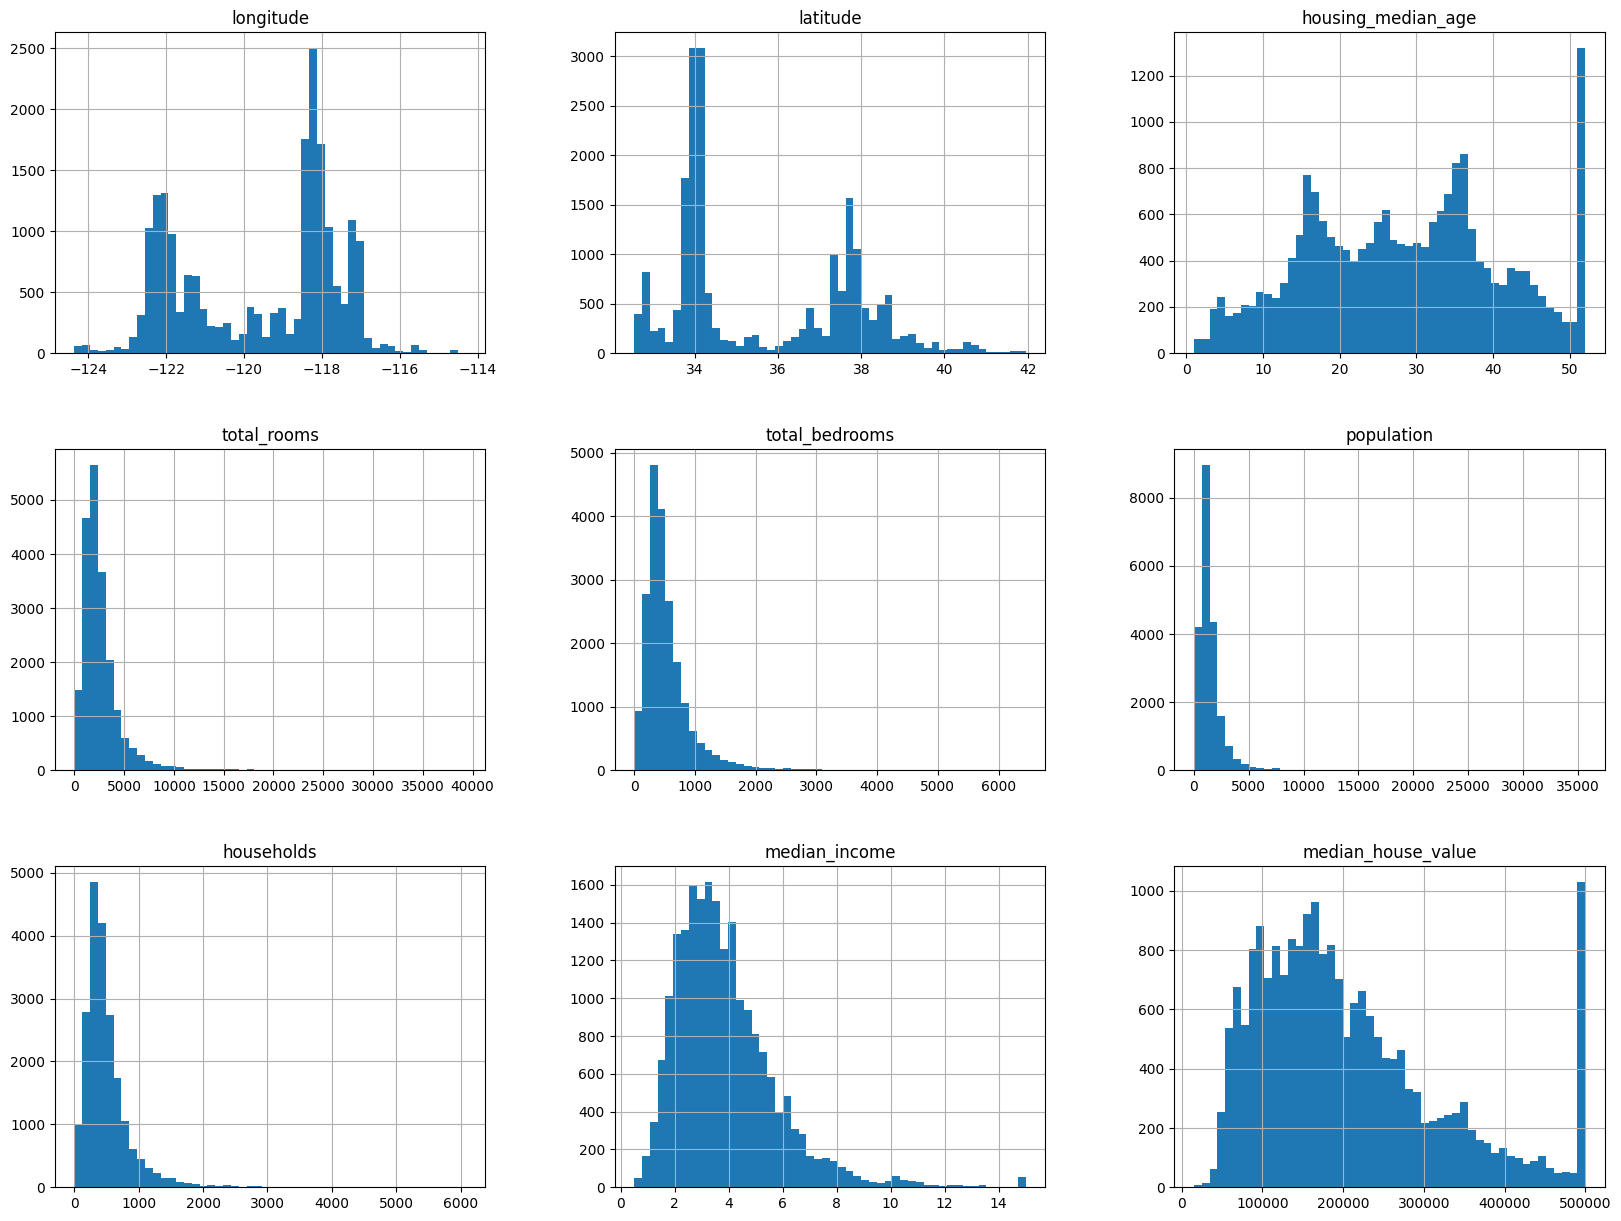

In [7]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

Observações dos Histogramas:

1. `median_income` não está expresso em dólares americanos. Dados dimensionados entre renda baixa (0.4999) a renda alta (15.0001).
2. `housing_median_age` e `median_house_value` também foram limitados.
3. Atributos têm escalas muito diferentes.
4. Têm uma calda longa (tail-heavy), se estendendo mais para direita da média do que para esquerda. Isso pode dificultar alguns algorítimos de aprendizagem de máquina.

#### Criando um conjunto de testes

Evitar o viés <i>data snooping</i>: No conjunto de teste, poderá encontrar um padrão de aprendizado de máquina não correspondente com o todo. Obtendo uma estimativa otimista demais.
<br><br>
<b>Forma 1</b> - Escolhendo aleatóriamente algumas instâncias, 20% do conjunto de dados:

In [8]:
def split_train_test(data:pd.DataFrame, test_ratio=0.2):
    np.random.seed(42) # para gerar os mesmos índices embaralhados
    shufled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shufled_indices[:test_set_size]
    train_indices = shufled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing)
print(len(train_set), len(test_set))

16512 4128


<b>Forma 2</b> - Usa o índice da linha como identificador exclusivo (ID), logo precisa garantir que novos dados sejam anexado ao fim e que nenhuma linha seja excluída. Calcula o hash do identificador de cada instância e coloca no conjunto de testes se o hash for menor ou igual a 20% do valor máximo dele. Garantindo que o conjunto de testes será consistente em várias execuções:

In [9]:
def test_set_check(identifier, test_ratio=0.2):
    return crc32(np.int64(identifier)) & 0xffffffff <= test_ratio * 2**32

def split_train_test_by_id(data:pd.DataFrame, test_ratio=0.2, id_column='index'):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # adiciona uma coluna 'index' 
train_set, test_set = split_train_test_by_id(housing_with_id)
print(len(train_set), len(test_set))

16512 4128


<b>Forma 3</b> - Caso não seja possível tente utilizar características mais estáveis para criar um ID. Por exemplo a latitude e longitude:

In [10]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, id_column='id')
print(len(train_set), len(test_set))

16322 4318


<b>Forma 4</b> - Utilizando a função train_test_split() do Scikit-Learn, que basicamente é semelhante a função que criamos split_train_test():

In [11]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), len(test_set))

16512 4128


<b>Forma 5</b> - Saindo de métodos de amostragem aleatórios. Especialistas alegam que a renda média (`median_income`) é um atributo muito importante para estimar os preços médios dos imóveis. Você que assegurar que o conjunto de testes represente as diversas categorias de rendimentos em todo o conjunto de dados:

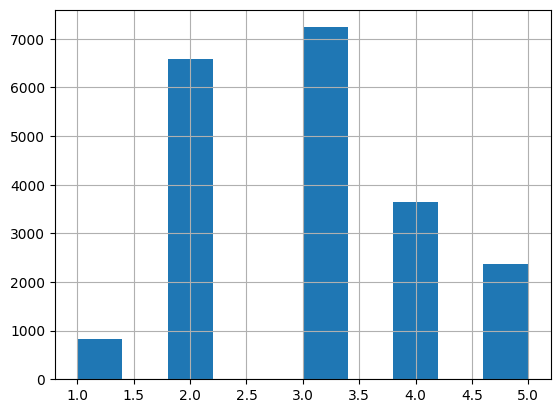

In [12]:
housing['income_cat'] = pd.cut( housing['median_income'],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()
plt.show()

In [13]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": housing['income_cat'].value_counts() / len(housing),
    "Stratified": strat_test_set['income_cat'].value_counts() / len(strat_test_set),
    "Random": test_set['income_cat'].value_counts() / len(test_set),
}).sort_index()

for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

compare_props

,Overall,Stratified,Random
income_cat,,,
1,0.039826,0.039971,0.040213
2,0.318847,0.318798,0.324370
3,0.350581,0.350533,0.358527
4,0.176308,0.176357,0.167393
5,0.114438,0.114341,0.109496


### Explore e Visualize os Dados para Obter Informações Úteis

In [14]:
housing = strat_train_set.copy()

#### Visualizando dados geográficos

Com a latitude e longitude é uma boa ideia criar um diagrama de dispersão para visualizar os dados de todas as regiões.

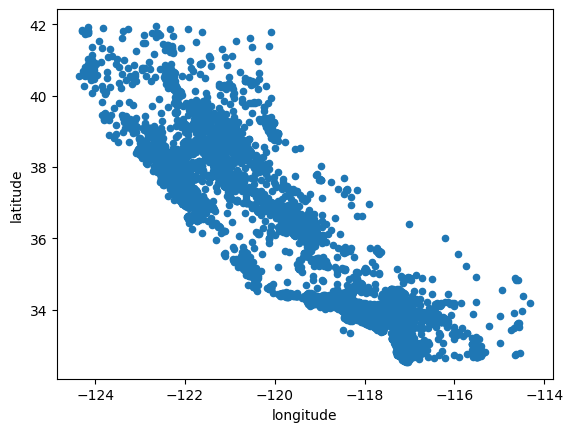

In [15]:
housing.plot(kind='scatter', x='longitude', y='latitude')
plt.show()

Definir alpha para 0.1 facilita muito a visualização dos locais que há uma alta densidade de pontos de dados.

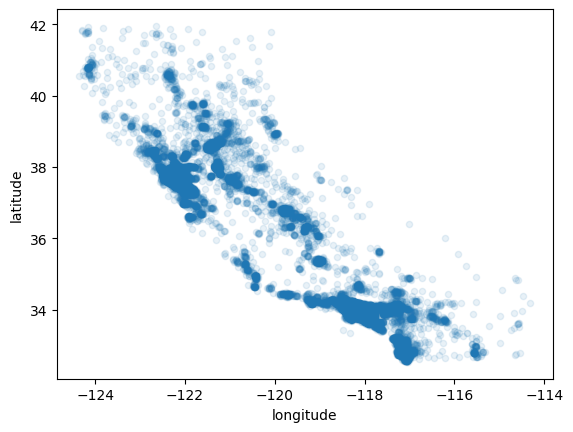

In [16]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.show()

O raio de cada círculo representa a população da região (`population`) e a cor representa o preço (`median_house_value`).<br>
Esse gráfico informa que os preços dos imóveis estão muitos relacionados à localização e a densidade populacional. Um algorítimo de <i>clustering</i> ajudaria muito a detectar o cluster principal e adicionar características novas que calculam a proximidade dos centros de cluster.

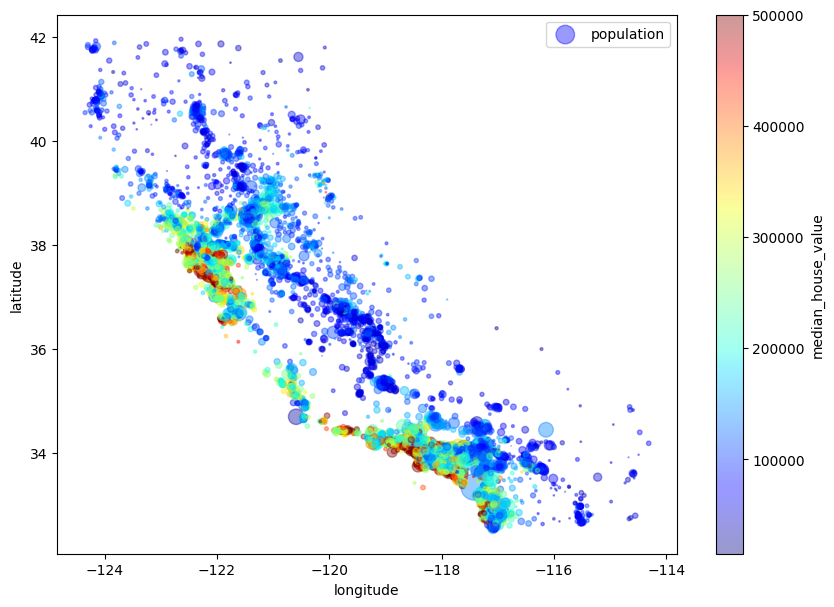

In [38]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.show()

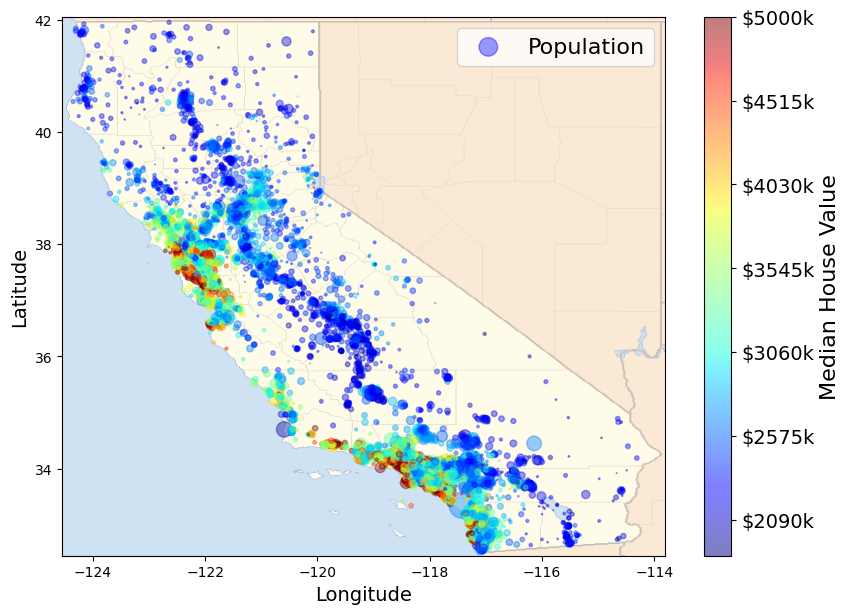

In [110]:
california_img = mpimg.imread('images/california.png')
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='Population', figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=False)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
         cmap=plt.get_cmap('jet'))
plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.legend(fontsize=16)

prices = housing['median_house_value']
tick_values = np.linspace(prices.min(), prices.max(), 11)
# colorbar ticks 0 to 1
cbar = plt.colorbar(ticks=tick_values/prices.max())
# prices.min() = 14999. -> $149k
# prices.max() = 500001. -> $149k
cbar.ax.set_yticklabels(["$%dk" % round(v/100) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.show()

### Buscando Correlações

In [112]:
corr_matrix = housing.corr()

ValueError: could not convert string to float: 'INLAND'